## Imports

In [1]:
#------------------ General Purpose Imports ---------------------#
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from timeit import default_timer as timer
import pickle

#------------------ Machine Learning Imports ---------------------#
import torch
import scipy
import torch.utils.data
from sklearn.model_selection import train_test_split

#------------------ Dataset imports ---------------------#
import dysts
from dysts import flows


In [2]:
#------------------ system imports ---------------------#
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../..')))

#------------------ reservoirgrid imports ---------------------#
from reservoirgrid.models import Reservoir
from reservoirgrid.helpers import utils
from reservoirgrid.helpers import viz
from reservoirgrid.helpers import chaos_utils
from reservoirgrid.helpers import reservoir_tests
#--------------------------------------------------------------#

## Loading System

In [3]:
result_path = "results/Chaotic/Lorenz/100.0.pkl"
with open(result_path , 'rb') as f:
    data = pickle.load(f)

## Best RMSE

In [4]:
Best_param_num = np.argmin([data[i]['metrics'] ['RMSE'] for i in range(len(data))]).item()
print(f"Parameters {Best_param_num} {data[Best_param_num]['parameters']}, RMSE = {data[Best_param_num]['metrics']['RMSE']}")
viz.compare_plot(datasets=[data[Best_param_num]['true_value'], data[Best_param_num]['predictions']], titles=["true","preds"], figsize=(1080,600))

Parameters 217 {'SpectralRadius': 1.0, 'LeakyRate': 0.3, 'InputScaling': 0.05}, RMSE = 0.2359138308288373


## Lyapunov of best RMSE

In [5]:
predictions  = data[Best_param_num]['predictions']
truth = data[Best_param_num]['true_value']
threshold = 0.1

print(f"Lyapunov of prediction {chaos_utils.lyapunov_time(predictions,threshold=0.1)}")
print(f"Error grows to {threshold} from the truth after {chaos_utils.comparative_lyapunov_time(truth, predictions, threshold=0.1)} time steps")

Lyapunov of prediction 1
Error grows to 0.1 from the truth after 3 time steps


## Other Parameters

In [17]:
select = 100
print(f"Parameters {select} {data[select]['parameters']}, RMSE = {data[select]['metrics']['RMSE']}")
viz.compare_plot(datasets=[data[select]['true_value'], data[select]['predictions']], titles=["true","preds"])

Parameters 100 {'SpectralRadius': 0.9, 'LeakyRate': 0.5, 'InputScaling': 0.4}, RMSE = 0.31274657056696303


## Lyapunov Analysis

In [18]:
predictions  = data[select]['predictions']
truth = data[select]['true_value']
threshold = 0.1
#print(chaos_utils.lyapunov_time_from_fit(true = truth, pred=predictions, fit_range=1))
print(f"Lyapunov of prediction {chaos_utils.lyapunov_time(predictions,threshold=2.1)}")
print(f"Lyapunov of ground truth {chaos_utils.lyapunov_time(truth,threshold=2.1)}")
print(f"Error grows to {threshold} from the truth after {chaos_utils.comparative_lyapunov_time(truth, predictions, threshold=0.1)} time steps")

Lyapunov of prediction 2500
Lyapunov of ground truth 178
Error grows to 0.1 from the truth after 18 time steps


In [8]:
#viz.plot_components(trajectory=predictions, figsize=(1080,600), line_width=1.5, title="Preds", labels=["X","Y","Z"])
#viz.plot_components(trajectory=truth, figsize=(1080,600), line_width=1.5, title="Truth", labels=["X","Y","Z"])

## Recurrnece Plot

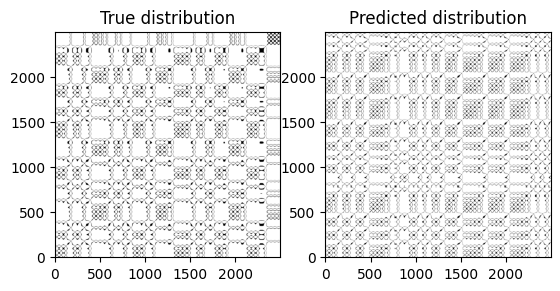

In [19]:
from pyts.image import RecurrencePlot

trajectory_true = truth[:, 0]  
trajectory_pred = predictions[:, 0]  

# RP object
rp = RecurrencePlot(threshold='point', percentage=10)

rp_true = rp.fit_transform(trajectory_true.reshape(1, -1))
rp_pred = rp.fit_transform(trajectory_pred.reshape(1, -1))

plt.subplot(1, 2, 1)
plt.imshow(rp_true[0], cmap='binary', origin='lower')
plt.title("True distribution")

plt.subplot(1, 2, 2)
plt.imshow(rp_pred[0], cmap='binary', origin='lower')
plt.title("Predicted distribution")
plt.show()

## KL Divergence

In [20]:
bins = 50  # or 100
all_data = np.vstack([truth, predictions])

# Compute common bin edges
ranges = [(np.min(all_data[:, i]), np.max(all_data[:, i])) for i in range(all_data.shape[1])]

H_true, _ = np.histogramdd(truth, bins=bins, range=ranges, density=True)
H_pred, _ = np.histogramdd(predictions, bins=bins, range=ranges, density=True)

# Flatten and normalize
P = H_true.flatten() + 1e-10
Q = H_pred.flatten() + 1e-10

P /= P.sum()
Q /= Q.sum()

In [21]:
from scipy.special import rel_entr

kl_div = np.sum(rel_entr(P, Q))  # KL(P || Q)
print("KL divergence:", kl_div)

KL divergence: 14.63157198561855


## Correlation dimension

Estimated Correlation Dimension D2 of true: 2.257055583948982 and of pred:  2.0743854322956743


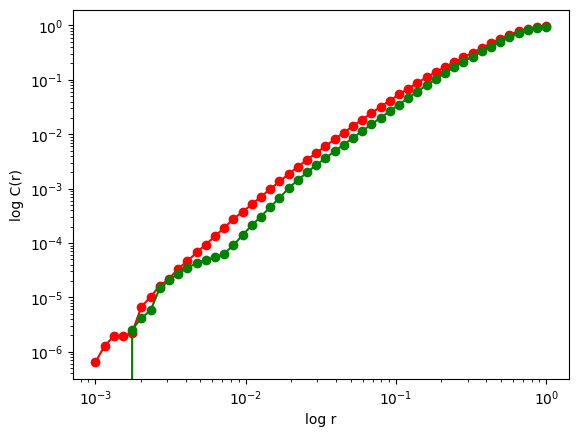

In [22]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

def correlation_dimension(data, r_vals):
    N = len(data)
    dists = squareform(pdist(data))  # pairwise distances
    C = []
    for r in r_vals:
        count = np.sum(dists < r) - N  # remove diagonal
        C_r = count / (N * (N - 1))
        C.append(C_r)
    return np.array(C)


r_vals = np.logspace(-3, 0, 50)
pred_c = correlation_dimension(predictions, r_vals)
true_c = correlation_dimension(truth, r_vals)

plt.loglog(r_vals, pred_c, 'o-', color = 'red' )
plt.loglog(r_vals, true_c, '-o', color = 'green' )
plt.xlabel("log r")
plt.ylabel("log C(r)")

# Fit slope in scaling region
fit_range = (r_vals > 0.01) & (r_vals < 0.1)
slope1 = np.polyfit(np.log(r_vals[fit_range]), np.log(pred_c[fit_range]), 1)[0]
slope2 = np.polyfit(np.log(r_vals[fit_range]), np.log(true_c[fit_range]), 1)[0]
print("Estimated Correlation Dimension D2 of true:", slope2, "and of pred: " , slope1)


## Power Spectral Density

Error in PSD (Lower is better): 7.1304115063718765
Cosine Similarity(Ideal Value 1): 0.7610679216880947
Wasserstein Distance(Ideal Value 0): 0.02064919400588408


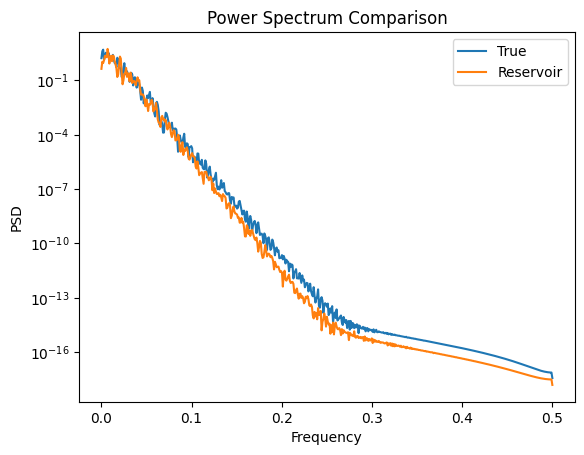

In [23]:
from scipy.signal import welch
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance


f, P_true = welch(truth[:, 0], fs=1.0, nperseg=1024)
_, P_pred = welch(predictions[:, 0], fs=1.0, nperseg=1024)

psd_error = np.linalg.norm(P_true - P_pred)
cos_sim = cosine_similarity(P_true.reshape(1, -1), P_pred.reshape(1, -1))[0][0]
emd = wasserstein_distance(P_true, P_pred)

plt.semilogy(f, P_true, label="True")
plt.semilogy(f, P_pred, label="Reservoir")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.title("Power Spectrum Comparison")
print(f"Error in PSD (Lower is better): {psd_error.item()}")
print(f"Cosine Similarity(Ideal Value 1): {cos_sim}")
print(f"Wasserstein Distance(Ideal Value 0): {emd}") # This does not seem very good. everything is close to 0

## Topological Data Analysis

In [29]:
from ripser import ripser
from persim import plot_diagrams, wasserstein

def filter_diagram(diag, threshold=1e-2):
    return np.array([pt for pt in diag if abs(pt[1] - pt[0]) > threshold])

diagrams_true = ripser(truth)['dgms']
diagrams_pred = ripser(predictions)['dgms']

#Earth-Movers Distance
dgm1 = filter_diagram(diagrams_true[1])
dgm2 = filter_diagram(diagrams_pred[1])
d = wasserstein(dgm1, dgm2)

Topological distance (H1):0.6544515925959258


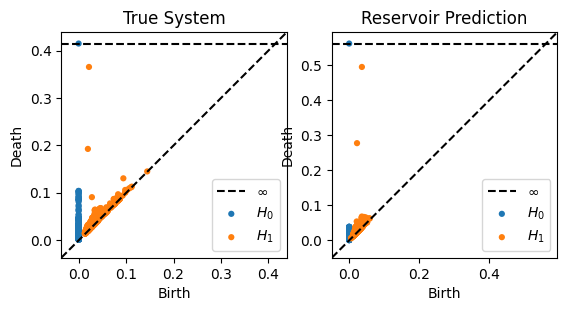

In [30]:
plt.subplot(1, 2, 1)
plot_diagrams(diagrams_true, title='True System')

plt.subplot(1, 2, 2)
plot_diagrams(diagrams_pred, title='Reservoir Prediction')

print(f"Topological distance (H1):{d}")